In [1]:
from osgeo import gdal
import numpy as np


In [2]:
path_rsimg = 'E:\开源\chenggong_tif.tif'

In [3]:
dset = gdal.Open(path_rsimg)
x_size, y_size, num_band = dset.RasterXSize, dset.RasterYSize,dset.RasterCount
print(x_size, y_size, num_band)

band_nir = dset.GetRasterBand(4)
band_nir_array = band_nir.ReadAsArray()
band_nir_array.shape
##先获取行数再列数，但是形状是先列再行，因为图像坐标原点左上角，地理（经纬）左下角

geo_trans = dset.GetGeoTransform()
print(geo_trans)

##老师视频里print结果宽度10，高度-10，-10因为y轴方向空间转换（地理与地图）相反
proj = dset.GetProjection()
print(proj)

D:\miniconda\lib\site-packages\osgeo\gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


2980 3261 6
(874420.0, 10.0, 0.0, 2769600.0, 0.0, -10.0)
PROJCS["WGS 84 / UTM zone 47N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",99],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [4]:
import matplotlib.pyplot as plt


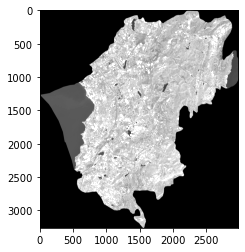

In [14]:
plt.figure()
plt.imshow(band_nir_array, vmax=4000,vmin=0,cmap='gray')

In [7]:
path_out = 'E:\开源\chenggong_nir_10m.tif'
##创建文件驱动
driver = gdal.GetDriverByName('GTiff')
outdset = driver.Create(path_out,xsize=band_nir_array.shape[1],
                        ysize=band_nir_array.shape[0],
                        bands=1,
                        eType=gdal.GDT_Int16)
outdset.SetGeoTransform(geo_trans)
outdset.SetProjection(proj)
outband = outdset.GetRasterBand(1)
outband.WriteArray(band_nir_array)
outband.SetNoDataValue(np.nan)
outdset = None



In [1]:
##重投影
from osgeo import gdal, osr

In [9]:
path_img = 'E:\开源\chenggong_tif.tif'
path_reproj = 'E:\开源\chenggong_wgs84.tif'

In [10]:
dset = gdal.Open(path_img)
proj = dset.GetProjection()
print(proj)

PROJCS["WGS 84 / UTM zone 47N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",99],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [11]:
utm_epsg = 32648
utm_wgs84 = 4326
utm = osr.SpatialReference()
utm.ImportFromEPSG(utm_epsg)

wgs84 = osr.SpatialReference()
wgs84.ImportFromEPSG(wgs84_epsg)

NameError: name 'wgs84_epsg' is not defined

In [5]:
##地理坐标系数包括：左上角角点、空间分辨率
##获得投影前的地理坐标参数
##在这之前需要先定义一个坐标转换的函数
##x_min_wgs84是经度，y_min_wgs84是纬度，因此需要修改输出次序
wgs84.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)
transform = osr.CoordinateTransformation(utm,wgs84)##两个参数，转换前与后

geo_trans = dset.GetTransform()
print(geo_trans[0], geo_trans[3])

##定义转换后的参数xyz，z一般为0
x_min_wgs84, y_min_wgs84, z_min_wgs84, z = transform.TransformPoint(geo_trans[0], geo_trans[3], 0)
print(x_min_wgs84, y_min_wgs84)
##输出结果先经后纬

NameError: name 'utm' is not defined

In [ ]:
##求取空间分辨率，怎么求？
##求每个像元的宽度，由整个影像的距离除像元个数
##已经知道了左上角点的位置，如果知道了右下角点的位置，就能知道影像距离
##右下角坐标怎么求？原始影像列数*像元宽度+左上角坐标
x_max_wgs84 = geo_trans[0] + geo_trans[1]*dset.RasterXSize
y_min_wgs84 = geo_trans[3] + geo_trans[5]*dset.RasterXSize
print(x_max_utm, y_min_utm)

x_max_wgs84, y_min_wgs84, _ =transform.Transformation(x_max_utm, y_min_utm, 0)
x_res = (x_max_wgs84-x_min_wgs84)/dset.RasterXSize
y_res = (y_max_wgs84-y_min_wgs84)/dset.RasterYSize
print(x_res, y_res)

In [ ]:
geotrans_wgs84 = []

In [ ]:
##目前空间分辨率未知，需要求，看上一格
geotrans_wgs84 = [102.703243415528, , 0, 24.93680372054124, 0, ]



In [ ]:
proj_utm_wkt = utm.ExportToWkt()
proj_wgs84_wkt = wgs84.ExportToWkt()

In [ ]:
##创建数据驱动
driver = gdal.GetDriverByName('GTiff')
dset_wgs84 = driver.Create(path_reproj,\
                           xsize = dset.RasterXSize,##重投影尺寸可一样可不一样，此处从原数据提取一样
                           ysize = dset.RasterYSize,
                           bands = dset.RasterCount,
                           eType = gdal.GDT_Int16,
                           )
##对创建的空数据集写出转入参数，参数暂且未知，需要求
dset_wgs84.SetGeoTransform()
dset_wgs84.SetProjection()


##重投影所用方法：
reproj = gdal.ReprojectImage(src_dc=dset,\
                            dst_ds=dset_wgs84,\
                                 src_wkt = proj_utm_wkt,
                                 dst_wkt = proj_wgs84_wkt,
                                    eResampleAlg = gdal.GRA_Bilinear
                                    )

In [11]:
##重采样(空间分辨率变化)
path_resam = 'E:\开源\chenggong_tif.tif'
res = 60

In [12]:
dset = gdal.Open(path_img)
geo_trans = dset.GetGeoTransform()
print(geo_trans)

(874420.0, 10.0, 0.0, 2769600.0, 0.0, -10.0)


In [13]:
##求可以被整除的空间分辨率
x_min, y_max = geo_trans[0], geo_trans[0]
x_max = x_min + geo_trans[1]*dset.RasterXSize
y_min = y_max + geo_trans[5]*dset.RasterYSize
print((x_min, y_max), (x_max, y_min))

(874420.0, 874420.0) (904220.0, 841810.0)


In [21]:
y_size = (y_max - y_min)/res
x_size = (x_max - x_min)/res
print(x_size, y_size)
##行数与列数是小数，需要设置为整型变量
x_size, y_max = int(x_size), int(y_size)
print(x_size, y_max)
res_x = (x_max - x_min)/x_size
res_y = (y_max - y_min)/y_size
print(res_x, res_y)

496.6666666666667 -14263.85
496 -14263
60.08064516129032 60.01696596641159


In [ ]:
geotrans_resample = [,60.08064516129032, 0.0 , , 61.03871897982448]

In [ ]:
##先创建驱动在创建数据集
##xsizeysize与原始不一样，重采样分辨率都变了，波段不变，空间参考不变
driver = gdal.GetDriverByName('GTiff')
dset_resam = driver.Create(path_resam,
                           xsize=?,
                           ysize=?,
                           bands=dset.RasterCount,
                           eType=gdal.GDT_Int16)
dset_resam.SetGetTransform(?)
dset_resam.SetProjecyion(dset.GetProj)
                         
resam = gdal.ReprojectImage(srs_de = dset,
                            dst_ds= dset_resam,
                            ??
                            )



dset_resam = None                            